In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor

from strinng.gui.mpldraw import MplArtist

In [3]:
training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

train_dataloader = DataLoader(training_data, batch_size=64)
test_dataloader = DataLoader(test_data, batch_size=64)

In [4]:
X, y = next(iter(train_dataloader))
X.shape

torch.Size([64, 1, 28, 28])

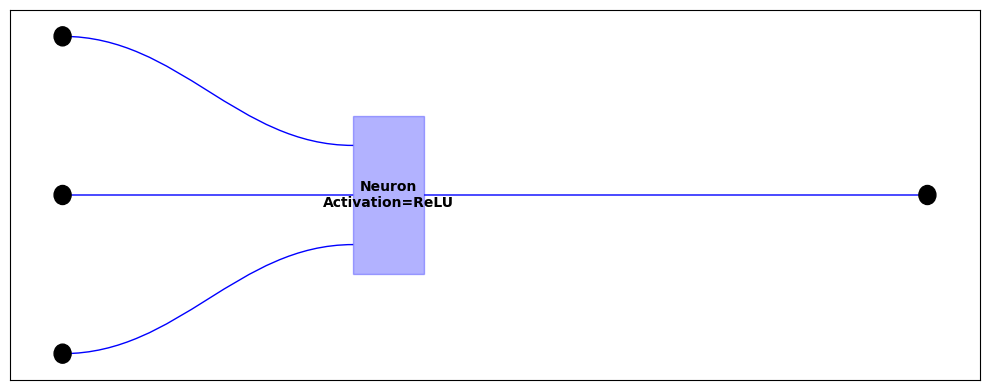

In [5]:
from strinng.generators import create_neuron

neuron = create_neuron(3, nn.ReLU)

MplArtist(neuron).draw(figsize=(10, 4))

In [33]:
from strinng.generators import create_fully_connected

input_layer = create_fully_connected(28 * 28, 64, nn.ReLU)
hidden_1 = create_fully_connected(64, 64, nn.ReLU)
hidden_2 = create_fully_connected(64, 32, nn.ReLU)
output_layer = create_fully_connected(32, 10, nn.Sigmoid)
network = input_layer >> hidden_1 >> hidden_2 >> output_layer

In [34]:
def train_loop(dataloader, model, optimizer, loss_fn):
    size = len(dataloader.dataset)
    # Set the model to training mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction and loss
        X = X.flatten(2, -1).squeeze()
        X = [X[:, i] for i in range(X.shape[-1])]
        pred = model(*X)
        pred = torch.stack(pred).T
        loss = loss_fn(pred, y)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * batch_size + len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

In [35]:
learning_rate = 1e-3
batch_size = 64
epochs = 5

In [36]:
from torch.nn import CrossEntropyLoss

optimizer = torch.optim.Adam(network.parameters(), lr=learning_rate)
loss_fn = CrossEntropyLoss()
train_loop(train_dataloader, network, optimizer, loss_fn)

loss: 2.392026  [  784/60000]
loss: 2.284654  [ 7184/60000]
loss: 2.243505  [13584/60000]
loss: 2.283536  [19984/60000]
loss: 2.155017  [26384/60000]
loss: 2.213324  [32784/60000]
loss: 2.169071  [39184/60000]
loss: 2.125652  [45584/60000]
loss: 2.170273  [51984/60000]
loss: 2.235727  [58384/60000]


NameError: name 'pred' is not defined